In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("reduced_health_Survey_GW.csv")

In [1]:
import os
os.mkdir("Figures")

## Data cleaning

In [3]:
# Rename diseases 
df.rename(columns = {
    "heal26": "diabetes",
    "heal27a": "hi_BP",
    "heal27b": "hi_chol",
    "heal27c": "lung_prob",
    "heal27d": "ment_health",
    "heal27e": "heart_disease",
    "heal27f": "cancer"
}, inplace = True)
df["healask"].replace({"Black non-hispanic": "Black non-Hispanic",
                     "White non-hispanic": "White non-Hispanic"}, inplace = True)

In [4]:
# BMI missing value = 99
df["bmi"].replace(99.9, np.NaN, inplace = True)
# Yes/no obese
conditions = [(df["bmi"]) >= 30, (df["bmi"] < 30)]
df["obese"] = np.select(conditions, [1,0])

In [5]:
# Multimorbidity
df[["diabetes", "hi_BP", "hi_chol", "lung_prob", "heart_disease",
    "cancer", "obese"]] = df[["diabetes", "hi_BP", "hi_chol", "lung_prob", "heart_disease",
                            "cancer", "obese"]].replace({"No": 0, "Yes": 1, "Refused": 0,
                              "Don't know": 0})
df["multimorbid"] = df[["diabetes", "hi_BP", "hi_chol",
           "lung_prob", "heart_disease", "cancer", "obese"]].sum(axis = 1)

In [6]:
# Race ns
race = df["healask"].value_counts().to_frame()
races = ["Hispanic", "Black non-Hispanic", "White non-Hispanic"]

In [7]:
# Time it takes to talk to park
df["walk_park"] = df["heal10min"].fillna(0) + 60*df["heal10hr"].fillna(0)

In [8]:
# Fruit/veg cost prohibitive
df["heal13"].replace({"Don't know": np.nan, "Refused": np.nan}, inplace = True)

# Fruit/veg daily servings
df["heal12"].replace({"None": 0}, inplace = True)
df["heal12_num"] = pd.to_numeric(df["heal12"])
df["heal12_num"] = df.apply(lambda x: x["heal12_num"] if x["heal12_num"] < 14 
                          else np.nan, axis = 1)

## Plots

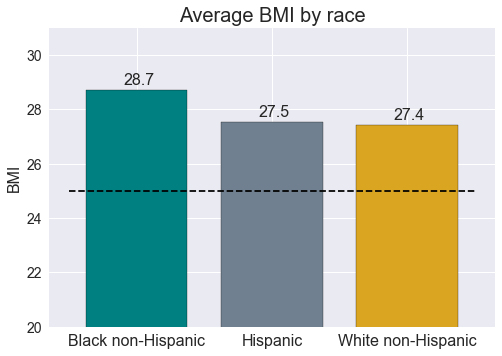

In [86]:
# BMI by race
bmi_race = df["bmi"].groupby(df["healask"]).mean().to_frame().reset_index()

colors = ["teal", "slategray", "goldenrod"]

race_pltclr = list(zip(["Black non-Hispanic", "Hispanic", "White non-Hispanic"]
                       ,colors))

plt.clf()
fig, ax = plt.subplots()
plt.bar(range(3), bmi_race["bmi"], width = .75,
       edgecolor = "black", color = colors)
plt.ylim(20, 31)
plt.ylabel("BMI", fontsize = 16)
plt.title("Average BMI by race", fontsize = 20)
ax.plot([-.5,2.5], [25,25], "k--")
plt.xticks(np.arange(3), bmi_race["healask"].unique(), fontsize = 16)
plt.yticks(fontsize = 14)
for i, v in enumerate(bmi_race["bmi"]):
    ax.text(i-.1, v+.2, str(round(v,1)), fontsize = 16)
plt.savefig("Figures/BMI_race.png")
plt.show()

In [22]:
# Percent with each chronic disease - data
disease = df[["healask","diabetes", "hi_BP", "hi_chol",
           "lung_prob", "heart_disease", "cancer", "obese"]]
disease.replace({"No": 0, "Yes": 1, "Refused": 0,
               "Don't know": 0}, inplace = True)

# Add column of ns of each race
disease_race = disease.groupby(disease["healask"]).sum()
disease_race = disease_race.merge(race,left_index=True,
                               right_index=True)
disease_race.rename(columns = {"healask": "n"}, inplace = True)

# Create df with percentages having each disease
disease_race_per = disease_race[["diabetes", "hi_BP", "hi_chol",
           "lung_prob", "heart_disease", "obese"]].div(disease_race.n, axis = 0)
disease_race_per = round(disease_race_per*100,2)
disease_race_per = disease_race_per.transpose().reset_index()
disease_race_per

disease_race_per

C:\Users\Cynthia\Anaconda3\lib\site-packages\pandas\core\generic.py:3725: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


,index,Black non-Hispanic,Hispanic,White non-Hispanic
0,diabetes,24.13,10.33,20.00
1,hi_BP,44.76,23.33,39.23
2,hi_chol,26.22,23.67,35.00
3,lung_prob,17.48,13.67,14.23
4,heart_disease,8.39,8.33,10.77
5,obese,31.82,21.00,23.46


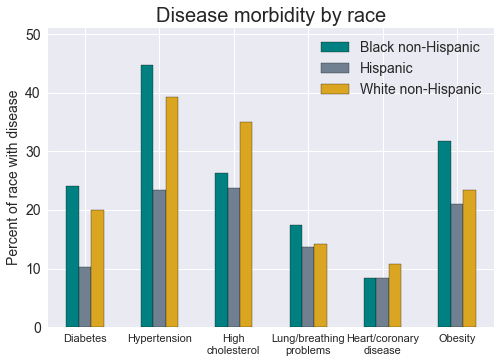

In [102]:
# Percent with each chronic disease - plot
diseases = ["Diabetes", "Hypertension", "High\ncholesterol",
           "Lung/breathing\nproblems", "Heart/coronary\ndisease", "Obesity"]
ax = disease_race_per.plot(kind = "bar", color = colors, 
                         ylim = [0,51], edgecolor = "black")
plt.ylabel("Percent of race with disease", fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(np.arange(6), diseases, rotation = 0, fontsize = 11)
ax.legend(loc='best', fontsize = 14)
plt.title("Disease morbidity by race", fontsize = 20)
plt.savefig("Figures/Morb_race.png")
plt.show()

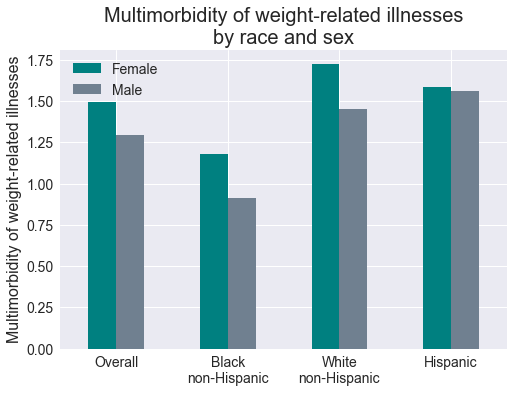

In [37]:
# Multimorbidity by race, gender
multi_race_gender = df[["multimorbid", "healask", "sex"]]
multi_race_gender_output = df[["multimorbid", "healask", "sex"]].groupby("sex").mean()
multi_race_gender_output = multi_race_gender_output.rename(columns = {"multimorbid": "Overall"})
df_label = ["Black\nnon-Hispanic", "White\nnon-Hispanic", "Hispanic"]
plt.clf()
for i, race in enumerate(races):
    multi_race_gender = df[["multimorbid", "healask", "sex"]][df["healask"] == race].groupby("sex").mean()
    multi_race_gender_output[df_label[i]]=multi_race_gender["multimorbid"]
multi_race_gender_output.transpose().plot(kind = "bar", color = colors)
plt.ylabel("Multimorbidity of weight-related illnesses", fontsize = 16)
plt.xticks(rotation = "horizontal", fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Multimorbidity of weight-related illnesses\nby race and sex",
         fontsize = 20)
plt.legend(fontsize = 14, loc = "upper left")
plt.savefig("Figures/multimorb_race_sex.png")
plt.show()

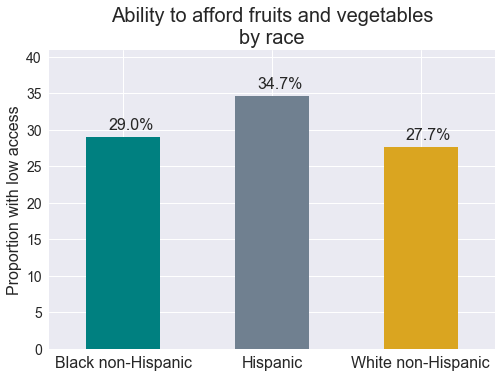

In [85]:
# Access to fruit/veg by race
race = df["healask"].value_counts().to_frame()
race_fruit = df[["healask", "heal13"]]
race_fruit = race_fruit.replace(["No", "Yes"], [0,1]).groupby("healask").sum()
race_fruit = race_fruit.merge(race, left_index=True, right_index=True)
race_fruit["Percent"] = round(100*race_fruit["heal13"]/race_fruit["healask"],2)
race_fruit = race_fruit["Percent"]
fig, ax = plt.subplots()
race_fruit.plot(kind = "bar", color = colors)
for i, v in list(enumerate(race_fruit)):
    ax.text(i-.1, v + 1, str(round(v,1))+"%", fontsize = 16)
plt.xticks(rotation = "horizontal", fontsize = 16)
plt.yticks(fontsize = 14)
plt.ylim(0,41)
plt.ylabel("Proportion with low access", fontsize = 16)
plt.title("Ability to afford fruits and vegetables\nby race",
         fontsize = 20)
plt.savefig("Figures/fruitveg_race.png")
plt.show()



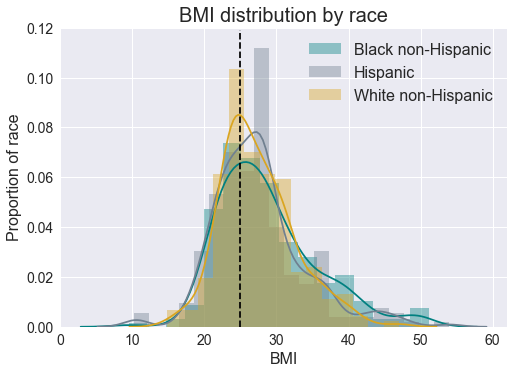

In [94]:
# Bmi distribution
plt.clf()
fig, ax = plt.subplots()
for race, color in race_pltclr:
    bmi_race = df["bmi"][(df["healask"] == race) & (df["bmi"] > 0)]
    sns.distplot(bmi_race, label = race, color = color)
    plt.legend(fontsize = 16)
plt.ylabel("Proportion of race", fontsize = 16)
plt.xlabel("BMI", fontsize = 16)
ax.plot([25,25], [0,.119], "k--")
plt.yticks(fontsize = 14)
plt.ylim(0,.12)
plt.xticks(fontsize = 14)
plt.title("BMI distribution by race", fontsize = 20)
plt.savefig("Figures/BMI_distrib_race.png")
plt.show()

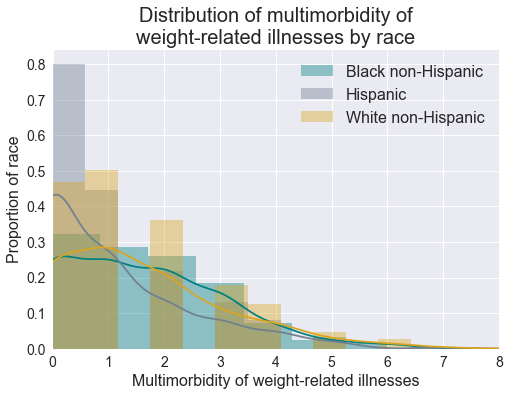

In [98]:
# Multimorbidity distribution by race
plt.clf()
for race, color in race_pltclr:
    mult_race = df["multimorbid"][(df["healask"] == race)]
    sns.distplot(mult_race, label = race, color = color)
    plt.legend(fontsize = 16)
plt.xlabel("Multimorbidity of weight-related illnesses", fontsize = 16)
plt.ylabel("Proportion of race", fontsize = 16)
plt.xlim(0,8)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Distribution of multimorbidity of\nweight-related illnesses by race", fontsize = 20)
plt.savefig("Figures/Multimorbid_distrib_race.png")
plt.show()

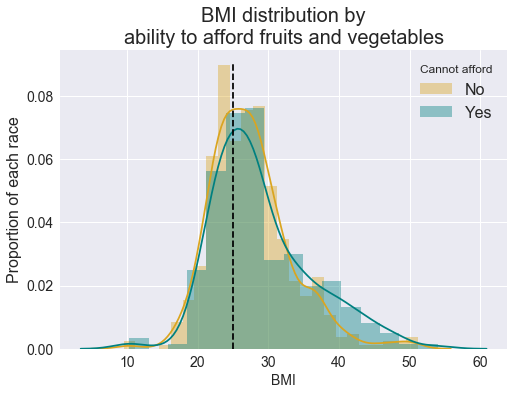

In [100]:
# BMI distribution by access
accessYN = ["No", "Yes"]
colors_bmi = ["goldenrod", "teal"]
plt.clf()
fig,ax = plt.subplots()
for i, access in enumerate(accessYN):
    bmi_access = df["bmi"][(df["heal13"] == access) &
                         (df["bmi"] > 0)]
    sns.distplot(bmi_access, label = access,
                color = colors_bmi[i])
    plt.legend(title = "Cannot afford", fontsize = 16)
plt.ylabel("Proportion of each race", fontsize = 16)
plt.xlabel("BMI", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("BMI distribution by\nability to afford fruits and vegetables",
         fontsize = 20)
ax.plot([25,25], [0,.09], "k--")
plt.savefig("Figures/BMI_fruitveg.png")
plt.show()